#### Explore TD-IDF for trending content

In [72]:
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re
import stopwordsiso as stopwordsiso
import emoji
from scipy.stats import median_abs_deviation
from rake_nltk import Rake
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
# Read data
posts=  pd.read_csv("../data/filtered_data/posts_transcripts.csv", encoding='utf-8')

In [74]:
posts['createTimeISO'] = pd.to_datetime(posts['createTimeISO'])

#### Data preprocessing

In [75]:
# stop word list
langs = ["en", "de"]
extra_stopwords = ["im", "like", "thing", "ok", "got", "youre", "omg", "pls", "tbh", "smh", "aint"]
stopwords_list = set(
    word for lang in langs for word in (stopwordsiso.stopwords(lang) or [])
).union(extra_stopwords)

def clean_text_keep_emojis_remove_stopwords(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+", " ", text)  # URLs, Mentions entfernen
    text = emoji.replace_emoji(text, replace=lambda e, data: f" {e} ")  # Emojis isolieren
    text = re.sub(r"[^a-zA-ZäöüÄÖÜß0-9\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", " ", text)
    text = re.sub(r"\s+", " ", text)
    tokens = [t for t in text.split() if t not in stopwords_list and len(t) > 2]
    return " ".join(tokens)

In [76]:
posts['transcribed_text'] = posts['transcribed_text'].apply(clean_text_keep_emojis_remove_stopwords)

#### Keyword and Trend extraction

**TF-IDF (Term Frequency–Inverse Document Frequency)**
- Computes importance of words by balancing:
  - Frequency in a post
  - Uniqueness across all posts
- *Use case:* High TF-IDF terms in recent posts can indicate emerging buzzwords

**RAKE (Rapid Automatic Keyword Extraction)**
- An unsupervised algorithm that finds key phrases by analyzing:
  - Word frequency
  - Word co-occurrences
- *Advantages:*
  - Fast and domain-independent
  - Useful for extracting multi-word phrases (e.g., “dewy skin”, “glass skin”)

**KeyBERT**
- A BERT-based method that uses embeddings to find keywords most representative of a document’s meaning
- *Advantages:*
  - Generates contextually relevant keywords using semantic understanding from the BERT model
  - Useful for capturing slang or nuanced phrases Gen Z might use

##### TF-IDF extraction

In [77]:
def extract_top_ngrams(texts, ngram_range=(2,3), top_n=20):
    vectorizer = TfidfVectorizer(
        max_features=100000,
        stop_words=None,
        ngram_range=ngram_range
    )
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # TF-IDF Score: Summe der TF-IDF Werte über alle Dokumente
    tfidf_scores = X.sum(axis=0).A1

    sorted_idx = tfidf_scores.argsort()[::-1]

    top_terms = [(feature_names[i], round(tfidf_scores[i], 4)) for i in sorted_idx[:top_n]]
    
    return top_terms

**Transcripts**

In [78]:
top_unigrams = extract_top_ngrams(posts['transcribed_text'], ngram_range=(1,1), top_n=30)
print("Top Unirams:", top_unigrams)

top_bigrams = extract_top_ngrams(posts['transcribed_text'], ngram_range=(2,2), top_n=30)
print("Top Bigrams:", top_bigrams)

top_trigrams = extract_top_ngrams(posts['transcribed_text'], ngram_range=(3,3), top_n=30)
print("Top Trigrams:", top_trigrams)


top_4_gram = extract_top_ngrams(posts['transcribed_text'], ngram_range=(4,4), top_n=30)
print("Top 4-grams:", top_4_gram)

Top Unirams: [('music', 442.5934), ('skin', 275.821), ('haut', 152.4746), ('skincare', 141.412), ('love', 122.7068), ('routine', 99.0907), ('transcription', 85.8134), ('serum', 85.7412), ('einfach', 74.1536), ('time', 70.4532), ('speech', 69.5647), ('guys', 65.2151), ('feel', 64.396), ('makeup', 63.658), ('cream', 63.222), ('yeah', 62.3679), ('baby', 61.5476), ('night', 61.0199), ('gonna', 60.7976), ('day', 59.8738), ('morning', 59.834), ('moisturizer', 58.1163), ('cleanser', 57.5765), ('glow', 55.7619), ('girl', 55.6991), ('care', 53.9367), ('toner', 53.7885), ('step', 52.6561), ('super', 51.7185), ('products', 46.1536)]
Top Bigrams: [('skincare routine', 62.3819), ('skin care', 31.4826), ('speech detected', 20.8768), ('music music', 19.5668), ('watching anxiety', 19.2626), ('hyaluronic acid', 18.6904), ('love love', 17.9889), ('skin barrier', 17.7148), ('eye cream', 17.6796), ('glass skin', 15.2198), ('dry skin', 14.9302), ('sensitive skin', 14.2066), ('dark spots', 12.7399), ('speec

Bigrams and Trigrams are the most important ones for us. Unigrams are to general but 4-grams are to long and only include word repetitions. So we will continue with bigrams and trigrams.

In [79]:
# only looking at posts from last 100 days
cutoff_date = posts['createTimeISO'].max() - pd.Timedelta(days=100)
recent_posts = posts[posts['createTimeISO'] >= cutoff_date]

top_keywords = extract_top_ngrams(recent_posts['transcribed_text'], ngram_range=(2,3), top_n=50)

clean_keywords = [ (phrase, count) for phrase, count in top_keywords if len(set(phrase.split())) > 1 ]

banned_phrases = ['speech video', 'speech detected']

clean_keywords = [phrase for phrase in clean_keywords if not any(banned in phrase for banned in banned_phrases)]

clean_keywords

[('skincare routine', 42.5753),
 ('skin care', 23.0312),
 ('eye cream', 12.2809),
 ('skin barrier', 12.2313),
 ('hyaluronic acid', 11.944),
 ('glass skin', 11.6211),
 ('dry skin', 9.9556),
 ('dark spots', 9.9239),
 ('sensitive skin', 9.3932),
 ('tiktok shop', 8.8483),
 ('aloe vera', 8.6032),
 ('anti aging', 8.2757),
 ('korean skincare', 8.0562),
 ('care routine', 7.8357),
 ('skin care routine', 7.4532),
 ('skin feels', 7.3754),
 ('milky toner', 7.1319),
 ('dead skin', 7.1248),
 ('trockene haut', 7.0402),
 ('spoken video', 7.0),
 ('pretty baby', 6.8086),
 ('morning skincare', 6.7961),
 ('cleansing oil', 6.7376),
 ('acne prone', 6.3454),
 ('double cleanse', 6.2179),
 ('spoken content', 6.0),
 ('skin feel', 5.9678),
 ('double cleansing', 5.94),
 ('vitamin serum', 5.874),
 ('white cast', 5.6357),
 ('oil cleanser', 5.3908),
 ('haut einfach', 5.2751),
 ('type girl', 5.2184),
 ('skincare products', 5.1925),
 ('nighttime skincare', 5.1887),
 ('cleansing balm', 5.0417),
 ('glowy skin', 5.0345),

This number is not the number of mentions but a weighted score by TF-IDF. TF-IDF penalizes words that appear very often as it's goal is to detect unsual, specific words and phrases. The value we are looking for depends on the total rows (text). 

In [80]:
# extract interesting phrases
exclude = {"skincare routine", "skin care"}
tracked_phrases = [phrase for phrase, _ in clean_keywords if phrase not in exclude][:8]
#tracked_phrases.append("glass skin")

tracked_phrases

['eye cream',
 'skin barrier',
 'hyaluronic acid',
 'glass skin',
 'dry skin',
 'dark spots',
 'sensitive skin',
 'tiktok shop']

#### Trends over time

In [81]:
# Filter: only include posts from 17.02.2025 onward
start_date = pd.to_datetime("2025-02-17", utc=True)
recent_posts = recent_posts[recent_posts["createTimeISO"] >= start_date]
recent_posts["date"] = pd.to_datetime(recent_posts["createTimeISO"]).dt.date

# Extract date and count posts per day
posts_per_day = recent_posts.groupby("date").size()

# Mark low-volume days (fewer than 20 posts)
low_activity_days = posts_per_day[posts_per_day < 20].index

# Compute phrase trends
phrase_trends = {}

for phrase in tracked_phrases:
    matching = recent_posts["transcribed_text"].str.contains(phrase, case=False, na=False)
    daily_mentions = recent_posts[matching].groupby("date").size()
    normalized = (daily_mentions / posts_per_day) * 100
    phrase_trends[phrase] = normalized

# Combine into DataFrame
trend_df_norm = pd.DataFrame(phrase_trends)

# fill real 0% values (phrase not mentioned)
trend_df_norm = trend_df_norm.fillna(0)

# Reapply NaN for low-activity days
trend_df_norm.loc[low_activity_days] = np.nan

In [82]:
trend_df_norm

,eye cream,skin barrier,hyaluronic acid,glass skin,dry skin,dark spots,sensitive skin,tiktok shop
date,,,,,,,,
2025-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-03,0.000000,0.000000,0.000000,3.571429,0.000000,0.000000,0.000000,0.000000
2025-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-07-06,0.000000,0.000000,0.000000,1.960784,0.000000,1.960784,0.000000,5.882353
2025-07-07,3.389831,3.389831,3.389831,5.084746,3.389831,5.084746,6.779661,1.694915
2025-07-08,1.449275,5.797101,1.449275,4.347826,5.797101,2.898551,1.449275,1.449275


In [83]:
def wide_to_long(trend_df: pd.DataFrame, date_col: str = None) -> pd.DataFrame:
    """
    Converts a wide-format DataFrame (index=days, cols=terms) into long-form
    with columns ['term', 'day', 'tfidf'].
    """
    df = trend_df.copy()
    # if the index isn't named, reset it as 'day'
    df = df.rename_axis(date_col or 'date').reset_index()
    long_df = df.melt(id_vars=[date_col or 'date'], var_name='term', value_name='tfidf')
    # drop NaNs or zeros (no signal)
    long_df = long_df.dropna(subset=['tfidf'])
    return long_df


In [84]:
def detect_keyword_trends(
    trend_df: pd.DataFrame,
    z_thresh: float = 2.5,
    smooth_win: int = 3,
    min_history: int = 5
) -> dict[str, float]:
    """
    Args:
      trend_df: long-form ['term','date','tfidf'] DataFrame.
    Returns:
      dict mapping term -> median/MAD z-score on most recent day.
    """
    # ensure 'date' datetime and sorted
    df = trend_df.copy()
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    all_days = sorted(df['date'].unique())

    scores = {}
    for term, grp in df.groupby('term'):
        grp = grp.sort_values('date')
        # map historical TF-IDF onto full calendar
        series = pd.Series(grp['tfidf'].values, index=grp['date'])
        series = series.reindex(all_days, fill_value=0)

        # require enough non-zero history
        nonzero = series.astype(bool).sum()
        if nonzero < min_history:
            continue

        # smoothing
        smoothed = series.rolling(window=smooth_win, min_periods=1, center=True).mean().values

        # robust z-score on last date
        hist = smoothed[:-1]
        med = np.median(hist)
        mad = median_abs_deviation(hist, scale='normal') or 1
        z = (smoothed[-1] - med) / mad
        if z > z_thresh:
            scores[term] = float(z)

    return scores

In [85]:
long = wide_to_long(trend_df_norm, date_col='date')
keyword_scores = detect_keyword_trends(long, z_thresh=3.5, smooth_win=3, min_history=5)


In [86]:
keyword_scores

{'skin barrier': 4.3154988888366885}

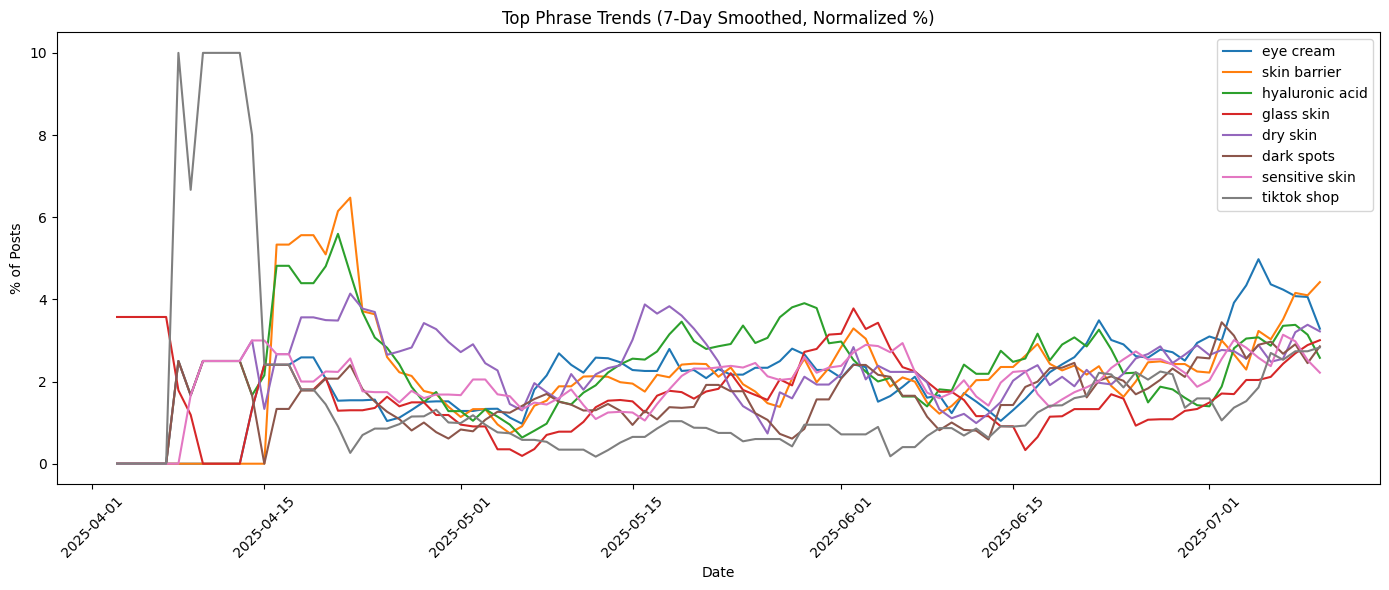

In [87]:
#For daily graph
trend_df_smoothed = trend_df_norm.rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(14,6))
for phrase in tracked_phrases:
    plt.plot(trend_df_smoothed.index, trend_df_smoothed[phrase], label=phrase)

plt.title("Top Phrase Trends (7-Day Smoothed, Normalized %)")
plt.ylabel("% of Posts")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

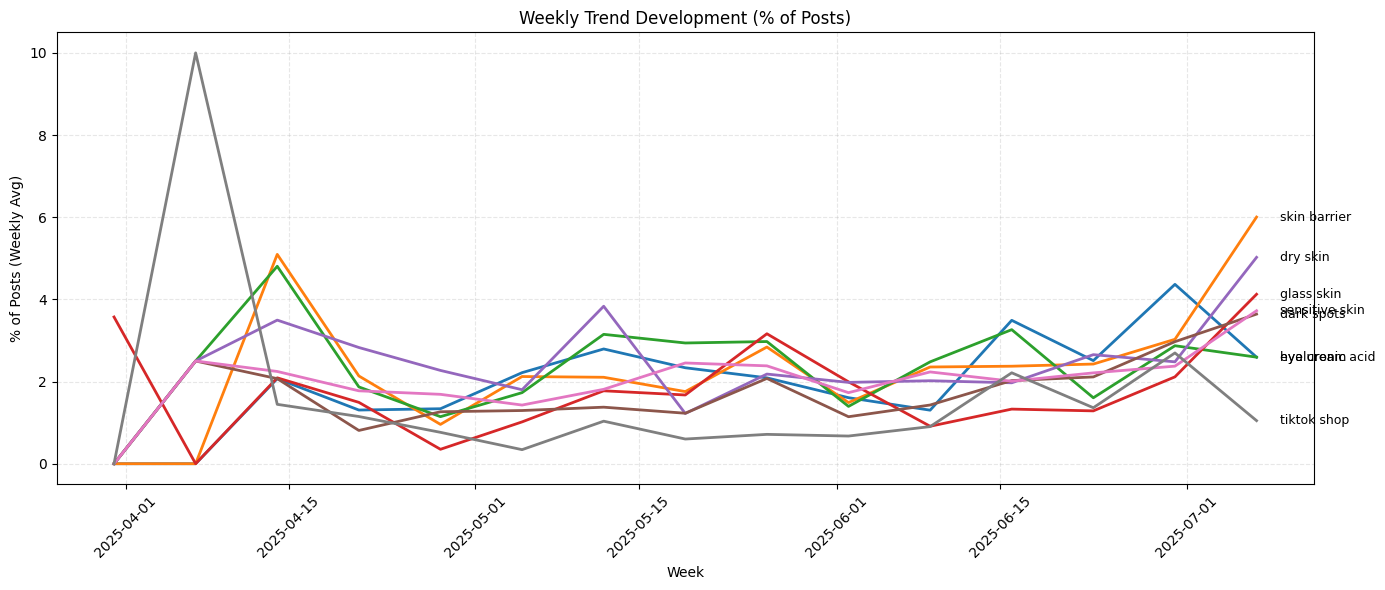

In [88]:
trend_df_norm.index = pd.to_datetime(trend_df_norm.index)

# Group by calendar week and compute weekly average
weekly_avg = (
    trend_df_norm
    .groupby(trend_df_norm.index.to_period("W"))[tracked_phrases]
    .mean()
)

# Convert index to timestamp for plotting
weekly_avg.index = weekly_avg.index.to_timestamp()


# Plot with labels at the end of each line
plt.figure(figsize=(14, 6))

for phrase in tracked_phrases:
    plt.plot(weekly_avg.index, weekly_avg[phrase], linewidth=2)
    # Add label at the last point
    y_last = weekly_avg[phrase].iloc[-1]
    plt.text(
        weekly_avg.index[-1] + pd.Timedelta(days=2),
        y_last,
        phrase,
        fontsize=9,
        verticalalignment='center'
    )

plt.title("Weekly Trend Development (% of Posts)")
plt.ylabel("% of Posts (Weekly Avg)")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

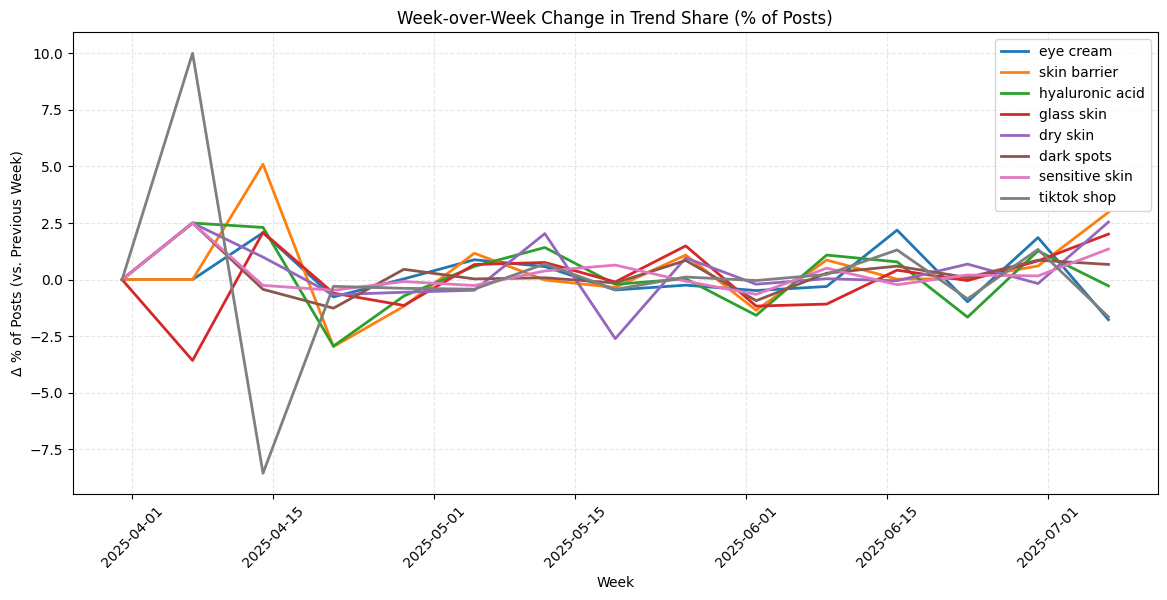

In [89]:
# Compute week-over-week change
weekly_change = weekly_avg.diff().fillna(0)

plt.figure(figsize=(14, 6))

for phrase in tracked_phrases:
    plt.plot(weekly_change.index, weekly_change[phrase], linewidth=2, label=phrase)

plt.title("Week-over-Week Change in Trend Share (% of Posts)")
plt.ylabel("Δ % of Posts (vs. Previous Week)")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.show()

#### Sentiment analysis on comments over time on top keywords

**Tracking how people talk about trends in their comments**

In [90]:
def filter_recent(df, date_col="createTimeISO", days=300):
    # Ensure datetime is timezone-aware and comparable
    df[date_col] = pd.to_datetime(df[date_col], utc=True, errors="coerce")
    start_date = pd.Timestamp.utcnow() - timedelta(days=days)
    return df[df[date_col] >= start_date].copy()


def add_phrase_flags(df, phrases, text_col, prefix=""):
    for phrase in phrases:
        col_name = f"{prefix}{phrase}"
        df[col_name] = df[text_col].str.contains(phrase, case=False, na=False)
    return df

def calculate_trend_sentiment(df, phrases, prefix="", sentiment_col="sentiment"):
    trend_sentiment = {}
    for phrase in phrases:
        subset = df[df[f"{prefix+phrase}"]]
        sentiment_counts = subset[sentiment_col].value_counts(normalize=True)
        trend_sentiment[phrase] = sentiment_counts
    return trend_sentiment

def prepare_time_series(df, date_col="createTimeISO"):
    df["date"] = pd.to_datetime(df[date_col]).dt.to_period("W").dt.to_timestamp()
    return df

def compute_sentiment_over_time(df, phrase, prefix="", sentiment_col="sentiment"):
    # All comments for volume
    df_phrase = df[df[f"{prefix+phrase}"]].copy()
    df_phrase["date"] = pd.to_datetime(df_phrase["createTimeISO"]).dt.to_period("W").dt.to_timestamp()

    # Only high-confidence comments for sentiment share
    df_confident = df_phrase[df_phrase["sentiment_confidence"] >= 0.65]

    # Compute sentiment share from confident subset
    counts = df_confident.groupby(["date", "sentiment"]).size().unstack(fill_value=0)
    shares = counts.div(counts.sum(axis=1), axis=0)

    # Compute total volume from all data
    volume = df_phrase.groupby("date").size()
    
    return shares, volume

def plot_sentiment_and_volume(shares, volume, phrase):
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    shares.plot(kind="bar", stacked=True, ax=ax1, color=["red", "lightgrey", "green"], width=0.8)
    ax1.set_ylabel("Share of Comments")
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Week")
    ax1.set_xticklabels(shares.index.strftime("%b %d"), rotation=45)
    ax1.legend(title="Sentiment", loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(volume.index.strftime("%b %d"), volume.values, color="black", marker="o", linewidth=2, label="Total Comments")
    ax2.set_ylabel("Total Comments")
    ax2.tick_params(axis='y', labelcolor="black")

    plt.title(f"Sentiment Share (Filtered by Confidence ≥ 0.65) vs. Total Comment Volume for '{phrase}'")
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()


In [91]:
def compute_weekly_sentiment(df, phrases, date_col="date", prefix="", sentiment_col="sentiment", sentiments=["positive", "negative"]):
    weekly_sentiment = {}
    for phrase in phrases:
        subset = df[df[f"{prefix+phrase}"]].copy()
        if subset.empty:
            continue

        counts = subset.groupby([date_col, sentiment_col]).size().unstack(fill_value=0)
        proportions = counts.div(counts.sum(axis=1), axis=0)

        # Keep only the specified sentiments
        weekly_sentiment[phrase] = proportions[sentiments]
    return weekly_sentiment

def plot_weekly_sentiment(weekly_sentiment, smoothing_window=0):
    for phrase, df in weekly_sentiment.items():
        df_to_plot = df.rolling(window=smoothing_window, min_periods=1).mean() if smoothing_window > 1 else df

        df_to_plot.plot(title=f"Sentiment Over Time: {phrase}", color=["green", "red"], figsize=(12, 4))
        plt.ylabel("Sentiment Share")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.show()


In [92]:
comments = pd.read_csv("../data/filtered_data/comments_sentiment.csv")

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_22651/1614282498.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("../data/filtered_data/comments_sentiment.csv")


/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_22651/871781911.py:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["date"] = pd.to_datetime(df[date_col]).dt.to_period("W").dt.to_timestamp()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_22651/871781911.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_phrase["date"] = pd.to_datetime(df_phrase["createTimeISO"]).dt.to_period("W").dt.to_timestamp()


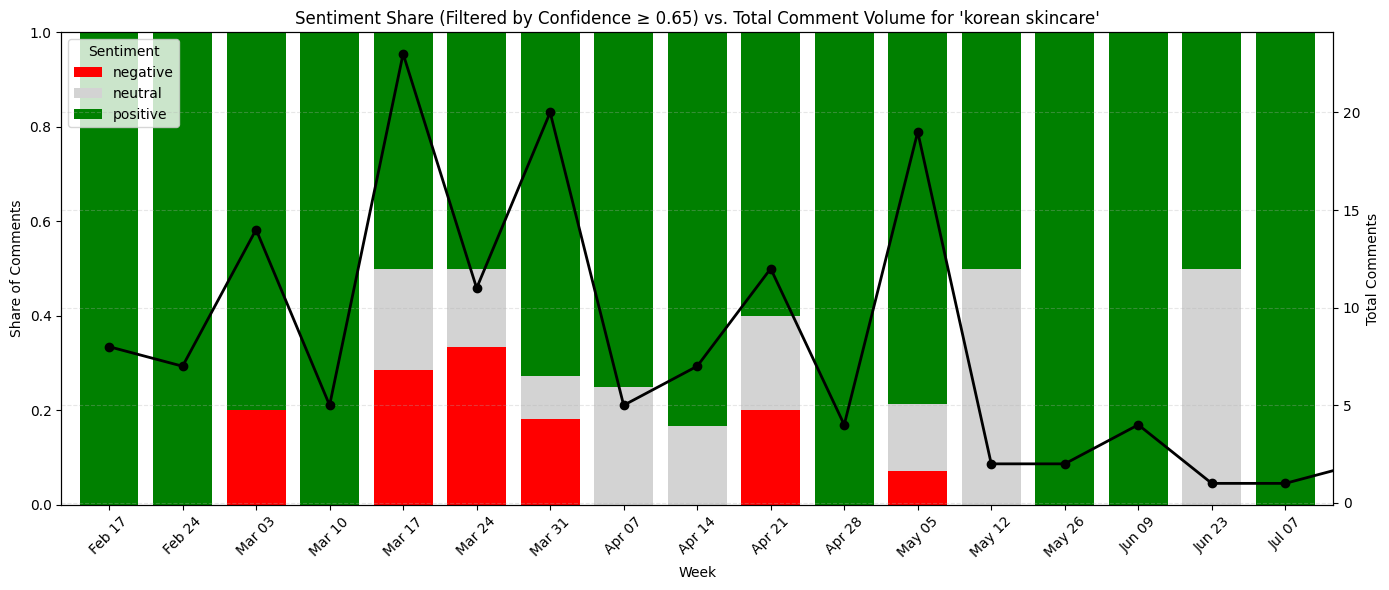

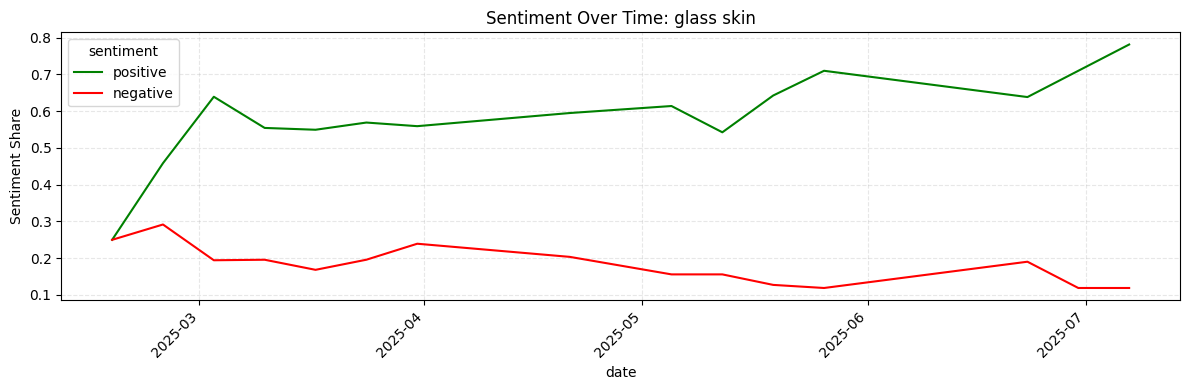

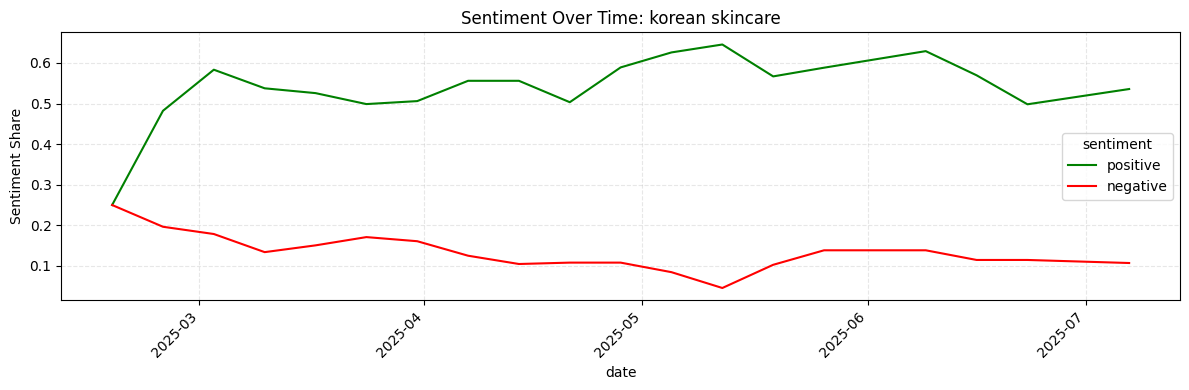

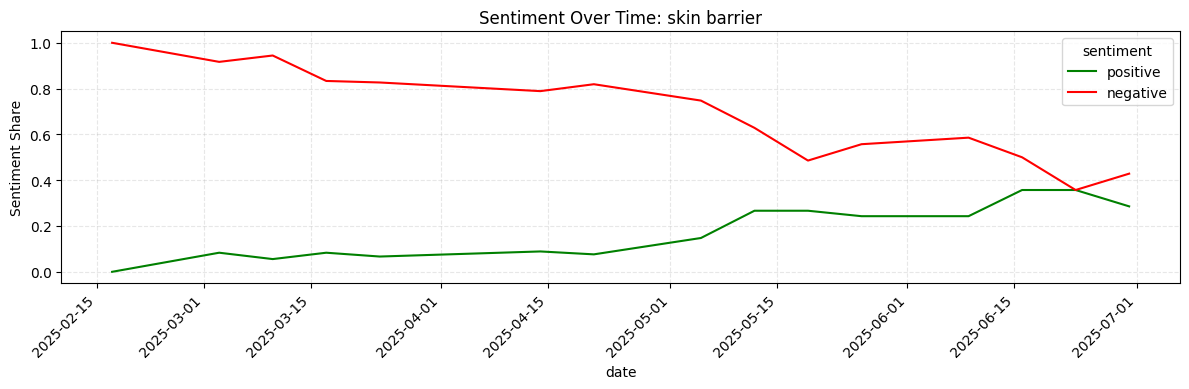

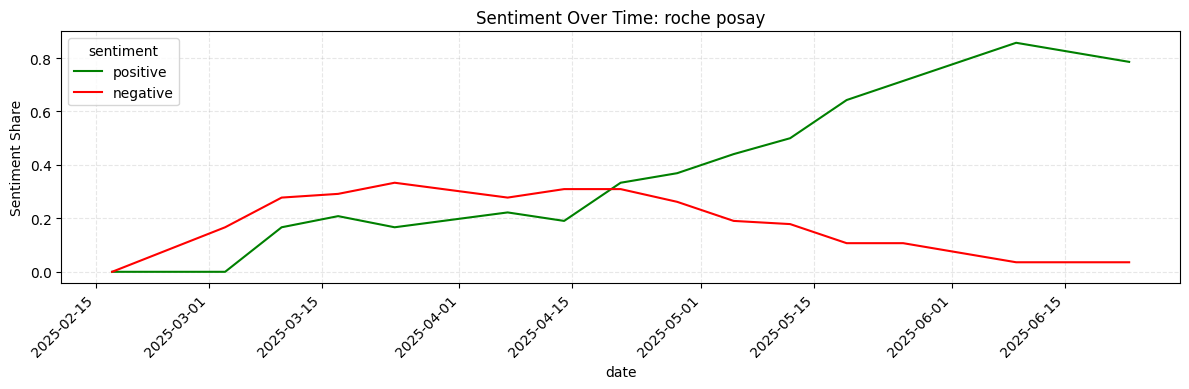

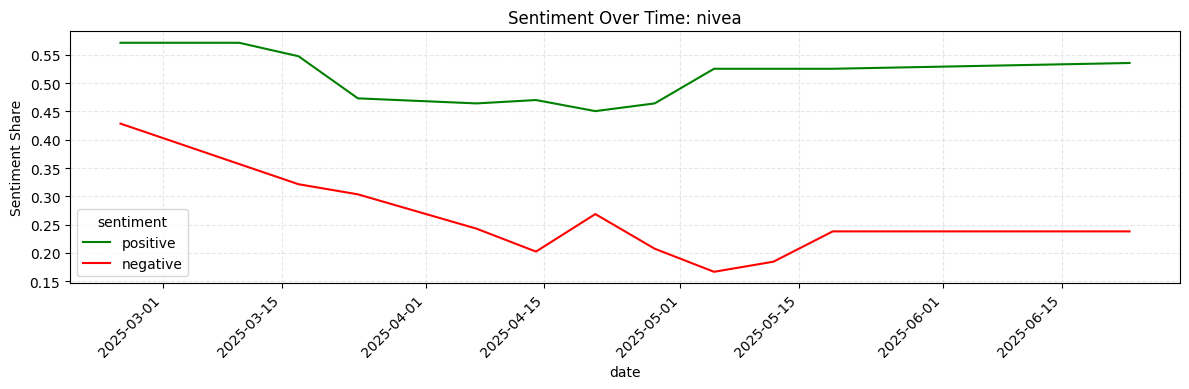

In [93]:
prefix="comment_has_"
recent_comments= filter_recent(comments, days=300)

trend_phrases = ["glass skin", "korean skincare",  "skin barrier", "roche posay", "nivea"]

recent_comments = add_phrase_flags(recent_comments, trend_phrases, text_col="comment", prefix=prefix)
trend_sentiment = calculate_trend_sentiment(recent_comments, trend_phrases, prefix=prefix)
recent_comments = prepare_time_series(recent_comments)

# For one phrase:
phrase = "korean skincare"
shares, volume = compute_sentiment_over_time(recent_comments,prefix=prefix, phrase = phrase)
plot_sentiment_and_volume(shares, volume, phrase)

weekly_sentiment = compute_weekly_sentiment(recent_comments, trend_phrases, prefix=prefix)
plot_weekly_sentiment(weekly_sentiment, smoothing_window=7)

**Tracking sentiments of all comments of a post that includes the keyword**

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_22651/871781911.py:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["date"] = pd.to_datetime(df[date_col]).dt.to_period("W").dt.to_timestamp()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_22651/871781911.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_phrase["date"] = pd.to_datetime(df_phrase["createTimeISO"]).dt.to_period("W").dt.to_timestamp()


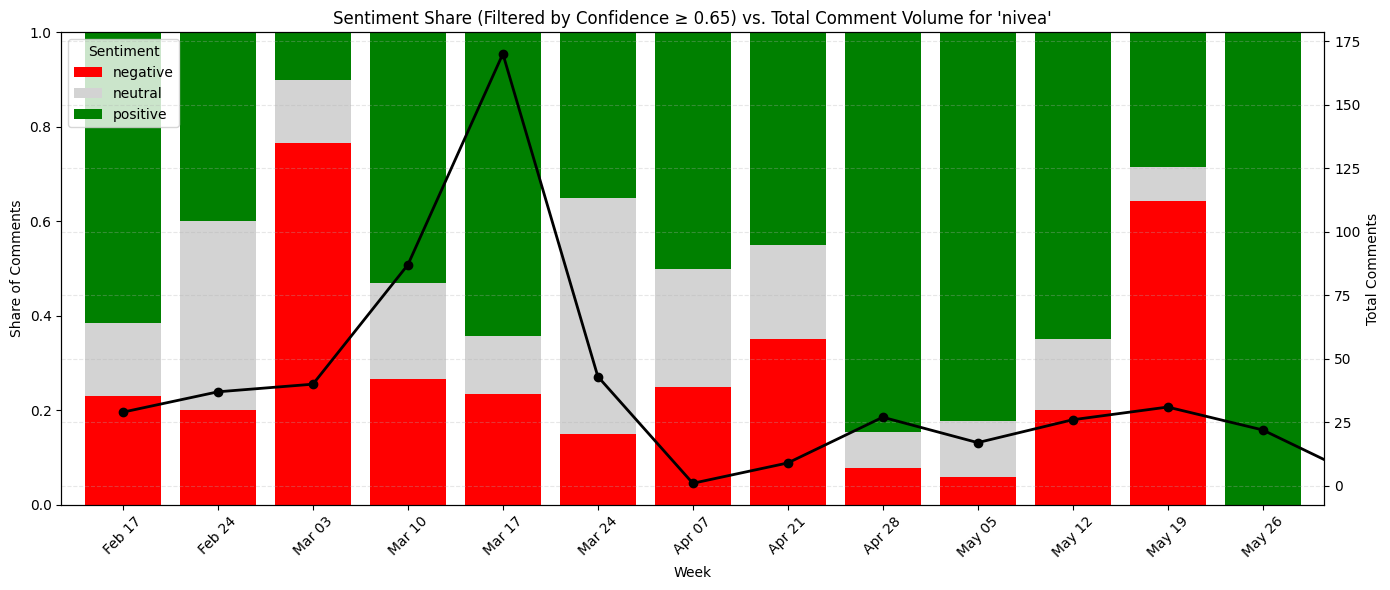

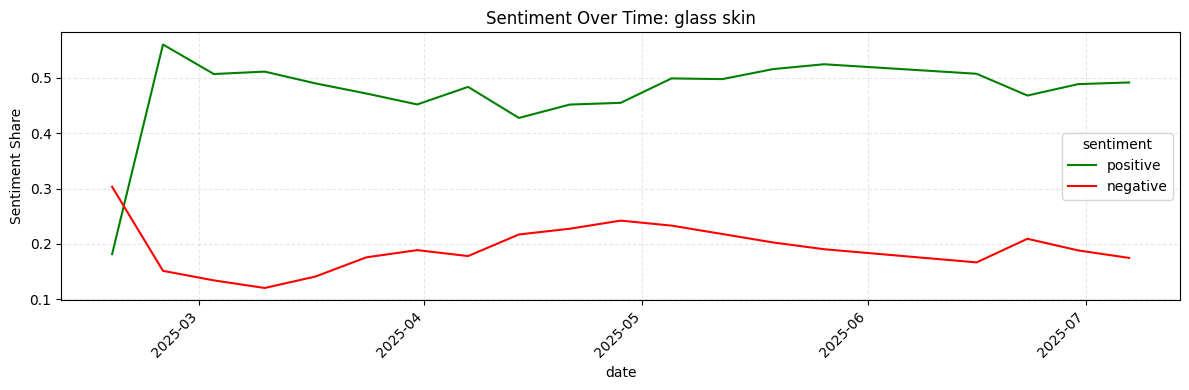

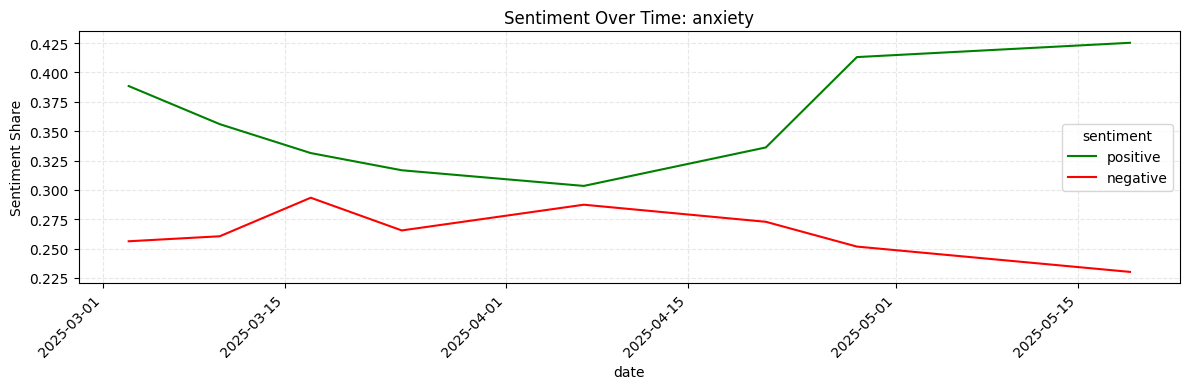

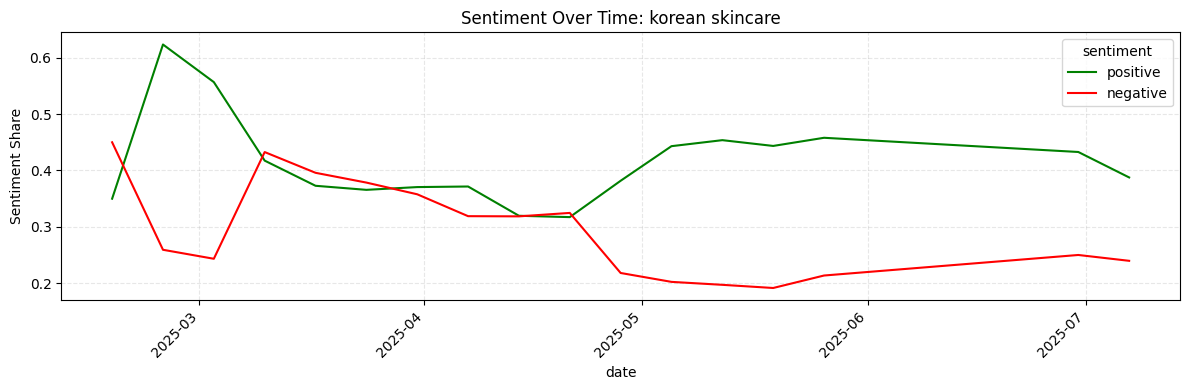

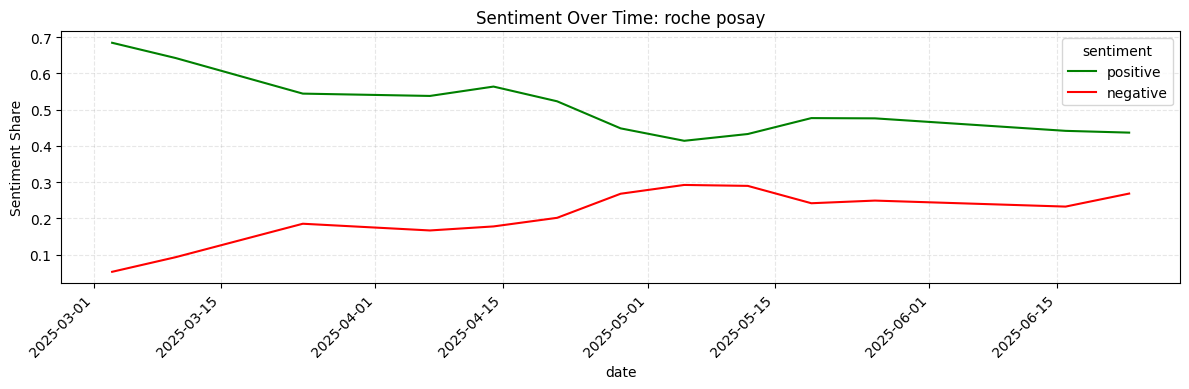

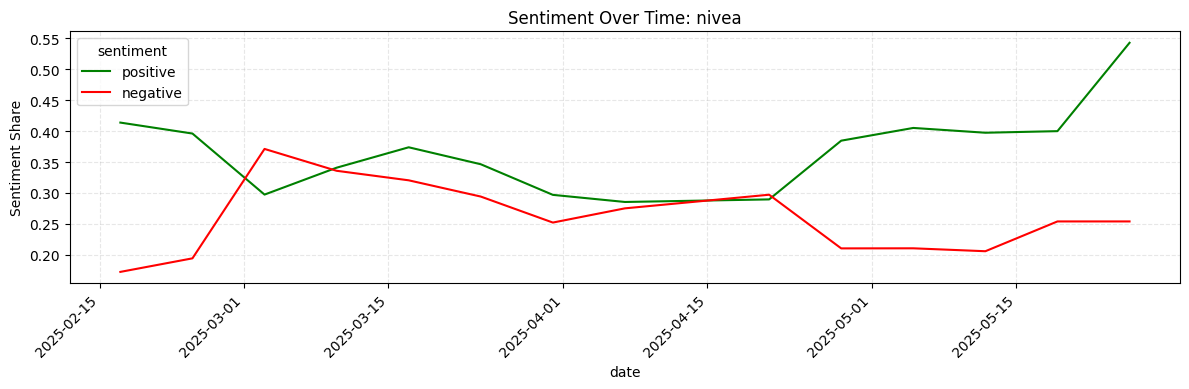

In [94]:
recent_comments= filter_recent(comments, days=300)
trend_phrases = ["glass skin", "anxiety", "korean skincare", "roche posay", "nivea"]

recent_comments_posts_sentiment = add_phrase_flags(df=recent_comments, prefix="caption_has_", phrases=trend_phrases, text_col="text")
recent_comments_posts_sentiment = add_phrase_flags(df=recent_comments, prefix="transcript_has_", phrases=trend_phrases, text_col="transcribed_text")

for phrase in trend_phrases:
    recent_comments_posts_sentiment[f"post_has_{phrase}"] = recent_comments_posts_sentiment[f"caption_has_{phrase}"] | recent_comments_posts_sentiment[f"transcript_has_{phrase}"]


trend_sentiment = calculate_trend_sentiment(df=recent_comments_posts_sentiment, phrases=trend_phrases, prefix="post_has_")
recent_comments_posts_sentiment = prepare_time_series(recent_comments_posts_sentiment)

# For one phrase:
phrase = "nivea"
shares, volume = compute_sentiment_over_time(df=recent_comments_posts_sentiment, phrase=phrase, prefix="post_has_")
plot_sentiment_and_volume(shares, volume, phrase)

weekly_sentiment = compute_weekly_sentiment(df=recent_comments_posts_sentiment, phrases=trend_phrases, prefix="post_has_")
plot_weekly_sentiment(weekly_sentiment, smoothing_window=7)

#### Reach of trends

In [95]:
def compute_trend_time_series_with_average(
    df,
    phrases,
    date_col,
    view_col="playCount",
    prefix="",
):
    df["date"] = pd.to_datetime(df[date_col]).dt.to_period("W").dt.to_timestamp()
    results = []

    for phrase in phrases:
        col = f"{prefix+phrase}"
        if col not in df.columns:
            continue

        subset = df[df[col]]
        if subset.empty:
            continue

        # Group by date and compute total + count
        grouped = subset.groupby("date")[view_col].agg(
            total_views="sum",
            post_count="count"
        ).reset_index()

        grouped["avg_views_per_post"] = grouped["total_views"] / grouped["post_count"]
        grouped["trend"] = phrase
        results.append(grouped)

    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()

def plot_trend_metric_over_time(df, value_col, title, ylabel):
    plt.figure(figsize=(14, 6))
    for phrase in df["trend"].unique():
        trend_data = df[df["trend"] == phrase]
        plt.plot(trend_data["date"], trend_data[value_col], marker="o", label=phrase)

    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlabel("Week")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_22651/4170935578.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["date"] = pd.to_datetime(df[date_col]).dt.to_period("W").dt.to_timestamp()


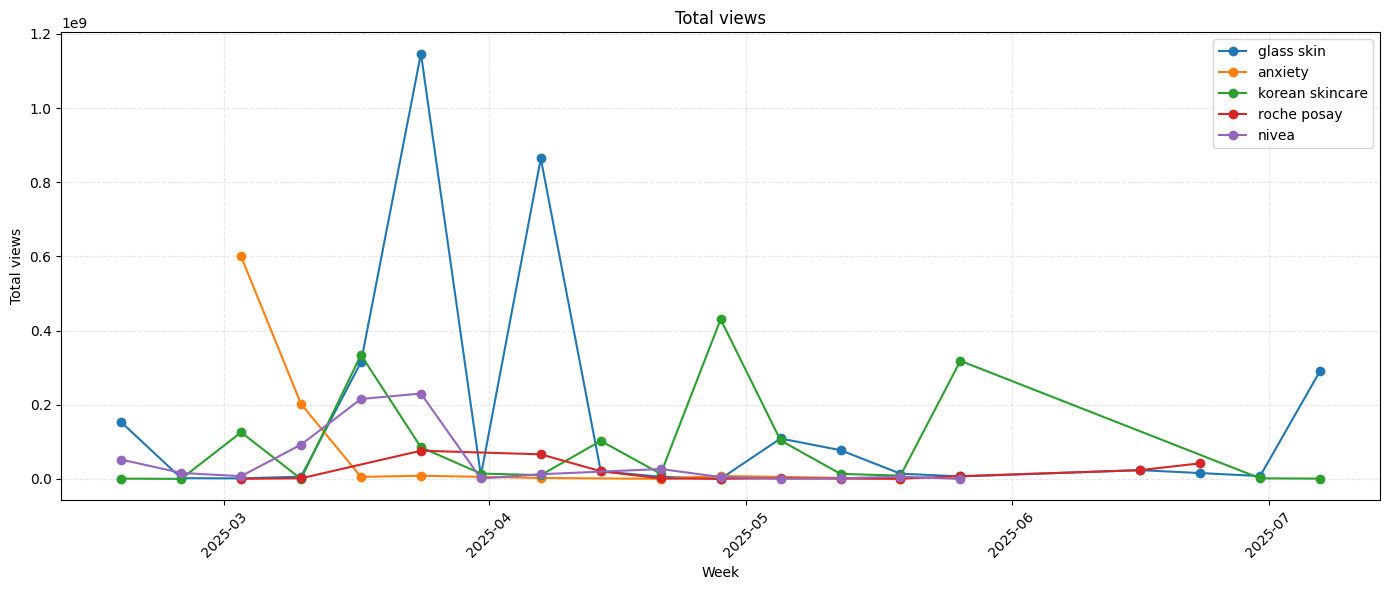

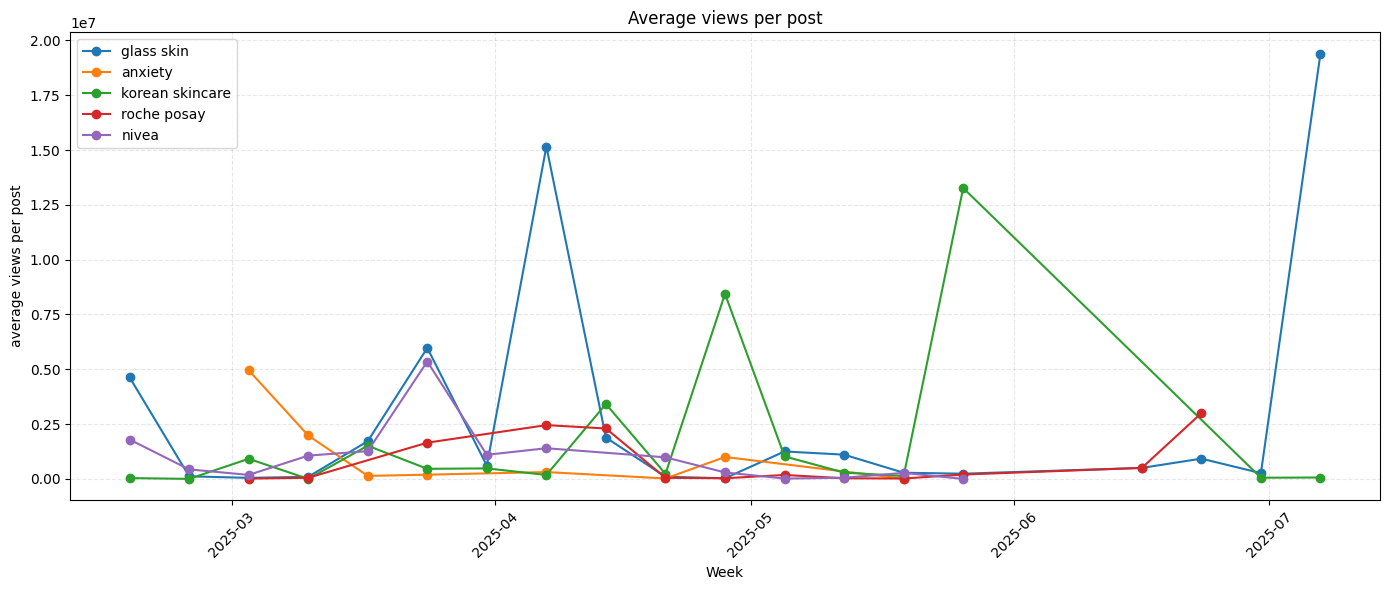

In [96]:
reach_overtime = compute_trend_time_series_with_average(recent_comments, trend_phrases, date_col="createTimeISO", prefix="post_has_")
plot_trend_metric_over_time(df=reach_overtime, value_col= "total_views", title="Total views", ylabel="Total views")
plot_trend_metric_over_time(df=reach_overtime, value_col= "avg_views_per_post", title="Average views per post", ylabel="average views per post")


In [97]:
def compute_trend_view_stats(df, phrases, view_col="playCount", text_col="text_post", prefix=""):
    
    # Compute view statistics
    data = []
    for phrase in phrases:
        flag_col = f"{prefix+phrase}"
        subset = df[df[flag_col]]
        total_views = subset[view_col].sum()
        post_count = len(subset)
        avg_views = total_views / post_count if post_count > 0 else 0
        data.append({
            "trend": phrase,
            "total_views": total_views,
            "post_count": post_count,
            "avg_views_per_post": avg_views
        })

    return pd.DataFrame(data).sort_values(by="total_views", ascending=False)

In [98]:
view_stats_df = compute_trend_view_stats(recent_comments_posts_sentiment, trend_phrases, prefix="post_has_")
print(view_stats_df)


             trend  total_views  post_count  avg_views_per_post
0       glass skin   3069684072        1012        3.033285e+06
2  korean skincare   1564273911        1097        1.425956e+06
1          anxiety    826709900         351        2.355299e+06
4            nivea    667279191         543        1.228875e+06
3      roche posay    242321060         327        7.410430e+05


#### RAKE on latest posts

In [99]:
def extract_trending_phrases(posts_df, days_back=7, top_n_phrases_per_post=3, top_trends=10, min_words=2, max_words=5):
    """
    Extract the most relevant phrases from recent posts using RAKE.
    
    Args:
        posts_df (pd.DataFrame): DataFrame with columns 'transcribed_text' and 'createTimeISO'
        days_back (int): How many days back to consider for analysis
        top_n_phrases_per_post (int): How many top phrases to extract per post
        top_trends (int): How many top trending phrases to return
        min_words (int): Minimum words in a phrase to include
        max_words (int): Maximum words in a phrase to include
        
    Returns:
        list: List of top trending phrases
    """
        
    # Filter: Keep only posts from the last `days_back` days
    recent_posts = posts_df[posts_df['createTimeISO'] >= (posts_df['createTimeISO'].max() - pd.Timedelta(days=days_back))]
    
    r = Rake()
    all_key_phrases = []
    
    for text in recent_posts['transcribed_text']:
        if isinstance(text, str) and text.strip() != "":
            r.extract_keywords_from_text(text)
            key_phrases = r.get_ranked_phrases()[:top_n_phrases_per_post]
            # Keep only phrases with length between min_words and max_words
            filtered_phrases = [phrase for phrase in key_phrases if min_words <= len(phrase.split()) <= max_words]
            all_key_phrases.extend(filtered_phrases)

    # Count occurrences of each phrase
    phrase_counts = Counter(all_key_phrases)
    # Get the top trending phrases
    trending_phrases = phrase_counts.most_common(top_trends)
    
    return trending_phrases

In [100]:
top_phrases = extract_trending_phrases(posts, days_back=30, top_n_phrases_per_post=3, top_trends=20)

top_phrases = [phrase for phrase in top_phrases if not any(banned in phrase for banned in banned_phrases)] #filter out "speech detected" and "speech video"

top_phrases = [ (phrase, count) for phrase, count in top_phrases if count >= 3 ] #filter out phrases with less than 3 mentions

top_phrases

[('skincare routine', 4)]